# Chapter 5) Support Vector Machines

A support vector machine (SVM) is a powerful ML model capable of performing linear and nonlinear classification, regression and even novelty detection.

SVMs shine for small to medium-sized nonlinear datasets (i.e., hundreds to thousands of instances) especially for classification tasks. However they dont scale very well to large datasets, as we will see.

In this chapter we will cover the core concepts of SVMs, how to use them, and how they work.

**Linear SVM Classification**

SVMs are best explained with some visuals.. Lets reuse a part of the iris dataset to illustrate.

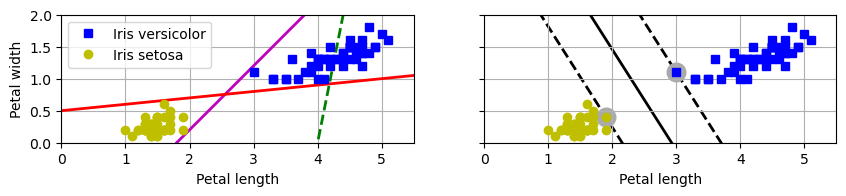

In [3]:
# extra code – this cell generates and saves Figure 5–1

import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5 * x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_

    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

# save_fig("large_margin_classification_plot")
plt.show()

The left plot shows the decision boundaries of 3 possible linear classifiers. 
 - The dashed one is pretty bad, it doesnt even separate the classes properly.
 - The other two seaprate the sets perfectly, but they come so close to the instances that they probably wont perform well on new instances.
 
In contrast, the solid line in the right plot represents the decision boundary of an SVM classifier; this line not only separates the two classes but also stays far away from the closest training instances as possible. 

We can think of an SVM as the widest possible street (represented by the parallel dashed lines) between the classes. This is called _large margin classification_.

Notice that adding more training instances 'off the street' will not affect the decision boundary at all; it is fully supported by the instances located on the edge of the street. These instances are called `support vectors`, they are circled in the above figure.

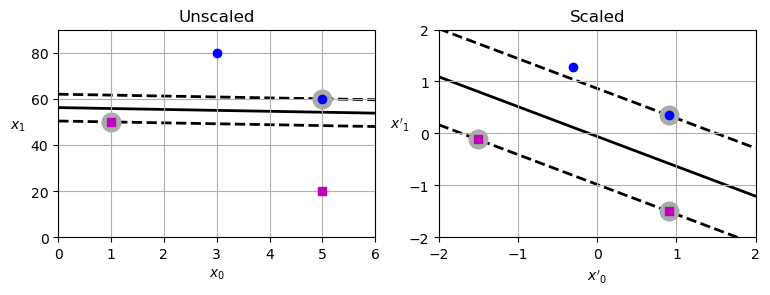

In [4]:
# extra code – this cell generates and saves Figure 5–2

from sklearn.preprocessing import StandardScaler

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100).fit(Xs, ys)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf_scaled = SVC(kernel="linear", C=100).fit(X_scaled, ys)

plt.figure(figsize=(9, 2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$")
plt.ylabel("$x_1$    ", rotation=0)
plt.title("Unscaled")
plt.axis([0, 6, 0, 90])
plt.grid()

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf_scaled, -2, 2)
plt.xlabel("$x'_0$")
plt.ylabel("$x'_1$  ", rotation=0)
plt.title("Scaled")
plt.axis([-2, 2, -2, 2])
plt.grid()

# save_fig("sensitivity_to_feature_scales_plot")
plt.show()

SVMs are sensitive to feature scales, if one feature scale is much larger, then the decision boundary may not be wide enough.

In example above, the left plot has vertical scale much larger than the horizontal scale (increments of 20 vs increments of 1). So the feature boundary is close to horizontal.
After feature scaling in the right plot, the decision boundary looks much better.


**Soft Margin Classification**

If we strictly impose that all instances must be _off the street_ and on the correct side, this called _hard margin classification_. There are two main issues with hard classification:-
 - It only works if the data is linearly separable
 - It is sensitive to outliers

In some cases, the outliers make it impossible to find a hard margin, or make it difficult to find a model that generalizes well.

To avoid these issues, we need to use a more flexible model. The objective is to find a good balance between keeping the street as large as possible and limiting the _margin violations_ (i.e. instances that end up in the middle of the street or on the wrong side). This is called _soft margin classification_.

**Nonlinear SVM Classification**

Although linear SVM classifiers are efficient and work well, many datasets are not linearly separable. One approach to handling these datasets is to add more features, such as polynomial features (like we did in Ch 4).

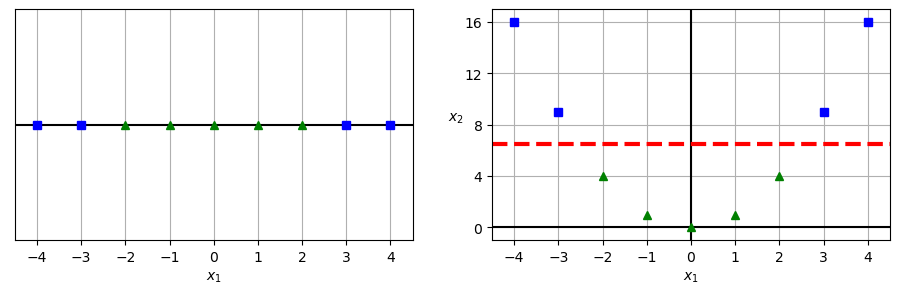

In [5]:
# extra code – this cell generates and saves Figure 5–5

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

# save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

The dataset is not linearly separable, as we see on the left. But if we add a second feature $x_2 = (x_1)^2$, the resulting 2D dataset is perfectly linearly separable.

To implement this idea using sk-learn, we can create a pipeline consisting of a `PolynomialFeatures` transformer, followed by a `StandardScaler` and a `LinearSVC` classifier.

Lets test this out on the `moons` dataset, in which the datapoints are shaped as two interleaving crescent moons.

In [6]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, random_state=42)
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

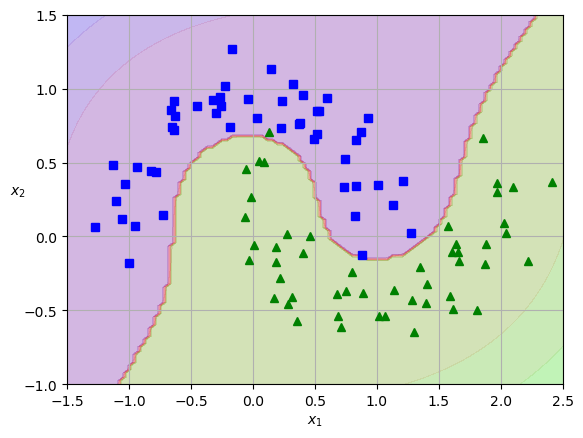

In [7]:
# extra code – this cell generates and saves Figure 5–6

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

# save_fig("moons_polynomial_svc_plot")
plt.show()

**Polynomial Kernel**

Adding polynomial features is simple to implement and works with all sorts of ML algorithms (not just SVMs). But, at a low degree they cannot deal with very complex datasets. Whereas at high degrees, it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs, you can apply an almost miraculous mathematical technique called the _kernel trick_. The kernel trick makes it possible to get the same result as you would if you had added many polynomial features, even with a high degree, _without actually having to add them_.

This means theres no combinatorial explosion of the number of features. This trick is implemented by the SVC class.

In [9]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

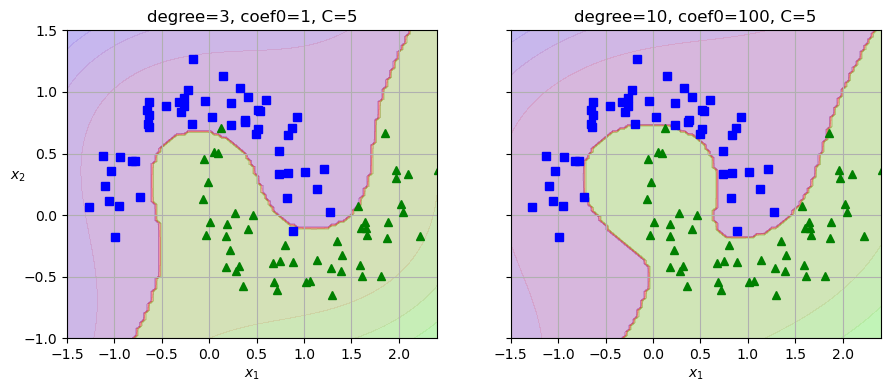

In [10]:
# extra code – this cell generates and saves Figure 5–7

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

# save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

on the left is a third-degree polynomial kernel

on the right is a 10th-degree polynomial kernel

The hyperparameter `coef0` controls how much the model is influenced by high-degree terms versus low-degree terms.

**Similarity Features**

Another trick to tackle non-linear problems is to add features computed using a similarity function, which measures how much each instance resembles a particular _landmark_ (as we did in Chapter 2 when adding geographic similarity features.)

For eg., lets take the 1D dataset from earlier, and add two landmarks to it at `x1 = -2` and `x1 = 1`. Next we'll define the similarity function to be the Gaussian RBF with $ \gamma = 0.3 $. This is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark).

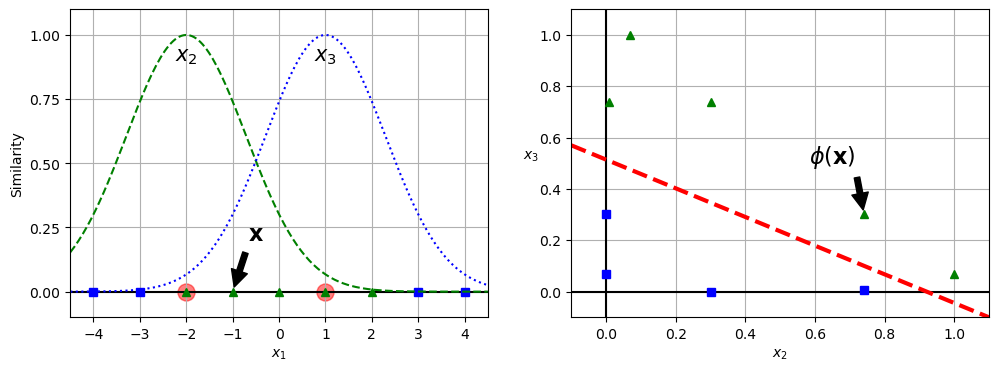

In [11]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r'$\mathbf{x}$',
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$  ", rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

# save_fig("kernel_method_plot")
plt.show()

Now we are ready to compute the new features. For example, lets look at the instance x1 = -1: it is located at a distance of 1 from the first landmark and 2 from the second landmark. Therefore, its new features are `x2 = exp(-0.3 x 1^2) = 0.74` and `x3 = exp(-0.3 x 2^2) = 0.3`.

The plot on the right shows the transformed dataset (dropping the original features). As you can see, its now linearly separable.

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance of the datset. Doing that creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. 

The downside is that a training set with `m` instances and `n` features gets transformed into a training set with `m` instances and `m` features (assuming you drop the original features. If your training set is very large, you end up with an equally large number of features.

**Gaussian RBF Kernel**

Just like the polynomial features method, the similarity features method can be useful with any ML algorithm, but it may be computationally expensive to compute all the additional features (especially on large training sets). Once again the kernel trick does its SVM magic, making it possible to obtain a similar result as if you had added many similarity features, but without actually doing so.

In [12]:
# Lets try the SVC method with the Gaussian RBF kernel

rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

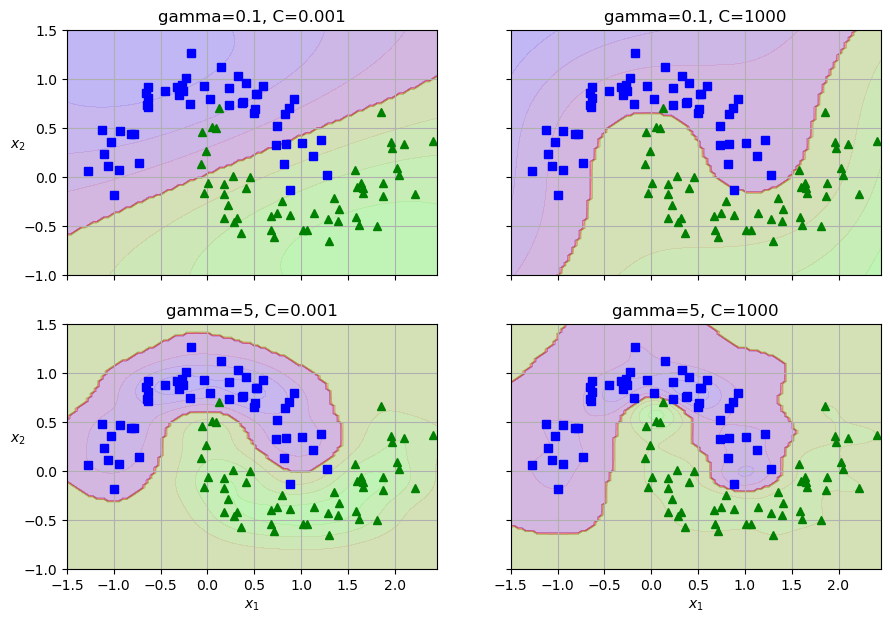

In [13]:
# extra code – this cell generates and saves Figure 5–9

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

# save_fig("moons_rbf_svc_plot")
plt.show()

the above model is represented in the bottom left (gamma = 5, C = 0.001).
The other plots show models trained on different values of the hyperparameters gamma $ \gamma $ and C.

Increasing gamma makes the bellshaped curve narrower, and vice versa when decreasing. So the gamma acts like a regularization parameter.

Other kernels exist, but are used much more rarely. Some of them are specialized for specific data structures. _String kernels_ are sometimes used when classifying text documents or DNA sequences.

**SVM Regression**


In [14]:
from sklearn.svm import LinearSVR

# extra code – these 3 lines generate a simple linear dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=42))])

To use SVMs for regression instead of classification, the trick is to tweak the objective. Instead of trying to find the largest possible street between two classes while limiting margin violations, SVM regression tries to fit as many instances as possible _on_ the street while limiting margin violations (i.e. instances _off_ the street).

The width of the street is controlled by a hyperparameter to $ \epsilon $

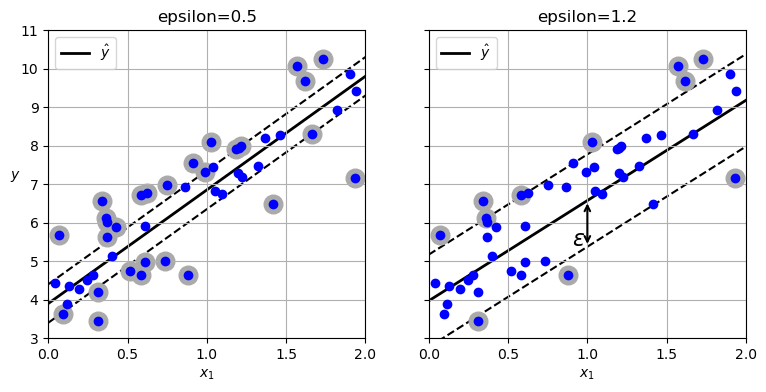

In [15]:
# extra code – this cell generates and saves Figure 5–10

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
# save_fig("svm_regression_plot")
plt.show()

Above figure shows two linear regression models trained on some linear data, left one has a small margin ($ \epsilon = 0.5 $), whereas right one has a larger margin ($ \epsilon = 1.2 $).

Reducing $ \epsilon $ increases the number of support vectors which regularizes the model.

To tackle non-linear tasks you can use a kernelized SVM model.

In [16]:
from sklearn.svm import SVR

# extra code – these 3 lines generate a simple quadratic dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

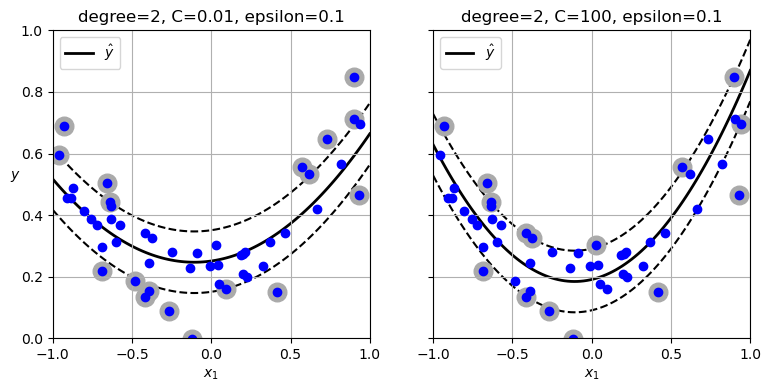

In [17]:
# extra code – this cell generates and saves Figure 5–11

svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
# save_fig("svm_with_polynomial_kernel_plot")
plt.show()

Above figure shows SVM regression on a random quadratic training set, using a second-degree polynomial kernel.

In [20]:
# the following code uses the SVR class (which supports the kernel trick)
# to produce the model represented on the left above.

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

The SVR class is regression equivalent to the SVC class, (same with LinearSVR and LinearSVC). The Linear classes scale linearly with the size of the training set, while the non-linear ones get much too slow when the training set gets very large. Also the linear classes dont support the kernel trick. Also the linear classes are optimized for linear SVMs.